# Anomaly detection using Autoencoders

Hi! We are going to build a model for Anomaly detection by looking at the ECG data from Time Series Classification website.

Let start by importing the dependencies, required for this analysis:

In [391]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import keras
from keras.models import Sequential
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Dataset
The original dataset for "ECG5000" is a 20-hour long ECG downloaded from Physionet. The name is BIDMC Congestive Heart Failure Database(chfdb) and it is record "chf07". It was originally published in "Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23)". The data was pre-processed in two steps: (1) extract each heartbeat, (2) make each heartbeat equal length using interpolation. This dataset was originally used in paper "A general framework for never-ending learning from time series streams", DAMI 29(6). After that, 5,000 heartbeats were randomly selected. The patient has severe congestive heart failure and the class values were obtained by automated annotation.


We will download the dataset from timeseriesclassification.com and combine train and test data and load the dataset into pandas dataframe and have a look at the data.

In [ ]:
!wget http://www.timeseriesclassification.com/Downloads/ECG5000.zip
!unzip ECG5000.zip
!cat ECG5000_TRAIN.txt ECG5000_TEST.txt > ecg_final.txt

In [393]:
data = pd.read_csv("ecg_final.txt", sep='  ', header = None)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [394]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


In [395]:
data.describe(include="all")

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.527400,-0.262476,-1.649511,-2.492211,-3.119443,-3.167438,-2.866308,-2.273126,-1.798127,-1.410124,...,0.146319,0.070973,-0.062914,-0.276206,-0.507667,-0.761043,-0.834741,-0.642263,-0.487242,-0.706008
std,0.760372,1.152369,1.445493,1.386409,1.302802,1.104382,0.906133,0.731627,0.623100,0.637149,...,1.171299,1.404842,1.646585,1.895134,2.059758,2.086218,2.056220,1.859296,1.830987,1.414465
min,1.000000,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,...,-3.971715,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227
25%,1.000000,-1.004511,-2.701576,-3.668096,-4.227247,-4.007470,-3.480479,-2.779941,-2.165851,-1.774124,...,-0.655753,-1.089300,-1.588885,-2.147449,-2.731550,-3.030509,-2.868331,-2.153513,-1.657771,-1.596692
50%,1.000000,-0.297541,-1.661892,-2.585677,-3.387934,-3.468718,-2.947061,-2.285578,-1.750157,-1.422570,...,0.473642,0.658318,0.717808,0.604747,0.334857,-0.030767,-0.195151,-0.194423,-0.160262,-0.565588
75%,2.000000,0.500061,-0.677290,-1.513964,-2.235369,-2.530967,-2.398813,-1.823494,-1.484923,-1.063708,...,1.062134,1.169420,1.238687,1.264471,1.234433,1.034584,0.945237,0.951681,1.002692,0.272012
max,5.000000,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,...,2.960969,3.007606,2.854680,2.912394,2.937685,3.351437,3.432518,3.579448,4.425976,7.402103


In [396]:
data.shape

(5000, 141)

Since there is no header in this dataset, we will rename all columns by adding a prefic c to the column names (that are just numbers right now: default by pandas)

In [397]:
data = data.add_prefix('c')

 So, there are 5000 records in the dataset. There are 140 ECG readings for each record and first column is a label,
 where value of 0 indicates Normal ECG and any value more than 1 is an anomaly in ECG.

Lets split the dataset into training and testing and make it ready for our model.

In [398]:
X_train, X_test, y_train, y_test = train_test_split(data.values, data.values[:,0:1], test_size = 0.2, random_state=101)

In [400]:
print('Training shape: {}'.format(X_train.shape))
print('Testing shape: {}'.format(X_test.shape))
print('\n')
print('Training shape: {}'.format(y_train.shape))
print('Testing shape: {}'.format(y_test.shape))

Training shape: (4000, 141)
Testing shape: (1000, 141)


Training shape: (4000, 1)
Testing shape: (1000, 1)


Let us standardize the data now.

In [319]:
scaler = StandardScaler()
scaler = scaler.fit(train_data)

In [401]:
X_train_scaled = data_scaled.transform(X_train)
X_test_scaled = data_scaled.transform(X_test)

Now we will divide the training dataset into normal ECG records and anomalous ECG records. We will train the data only on Normal records but we will validate on dataset that have both normal and anomalous records.

In [403]:
normal_X_train = pd.DataFrame(X_train_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_X_train = pd.DataFrame(X_train_scaled).add_prefix('c').query('c0 > 0').values[:,1:]

In [405]:
normal_X_test = pd.DataFrame(X_test_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_X_test = pd.DataFrame(X_test_scaled).add_prefix('c').query('c0 > 0').values[:,1:]

Let us look at few examples of normal and anomalous records:

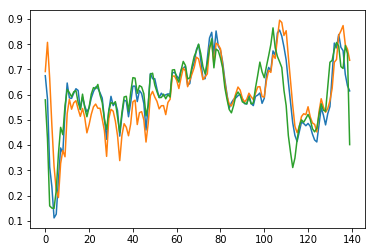

In [406]:
plt.plot(normal_X_train[0])
plt.plot(normal_X_train[1])
plt.plot(normal_X_train[2])

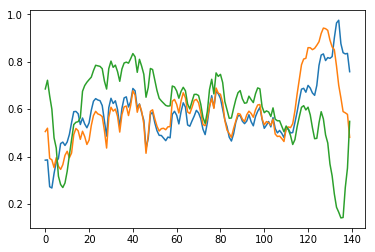

In [407]:
plt.plot(anomaly_X_train[0])
plt.plot(anomaly_X_train[1])
plt.plot(anomaly_X_train[2])

As we can see from the plot, normal ECG records line up very well and overlap in majority of space. Records with anamoly on the other hand have much variation in the data and diverge more from the norm.

# Build the model
We will use common architecture for our Autoencoder model. We will deconstruct our data gradually with each layer,
upto layer with 8 hidden units and then we will reconstruct it back to the 140, shape of our input.

In [408]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dense(8, activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dense(140, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='mae')


In [410]:
history = model.fit(normal_X_train, normal_X_train,
                   epochs = 50,
                   batch_size = 128,
                   validation_data = (X_train_scaled[:,1:], X_train_scaled[:,1:]),
                   shuffle=True,
                   callbacks = [early_stopping])

Epoch 1/50
19/19 [==============================] - 1s 43ms/step - loss: 0.1281 - val_loss: 0.1126
Epoch 2/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0798 - val_loss: 0.0820
Epoch 3/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0550 - val_loss: 0.0770
Epoch 4/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0490 - val_loss: 0.0761
Epoch 5/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0480 - val_loss: 0.0758
Epoch 6/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0477 - val_loss: 0.0755
Epoch 7/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0475 - val_loss: 0.0751
Epoch 8/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0471 - val_loss: 0.0743
Epoch 9/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0461 - val_loss: 0.0725
Epoch 10/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0435 - val_loss: 0.0694
Epoch 11/50
19/19 

In [412]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 64)                9024      
_________________________________________________________________
dense_51 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_52 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_53 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_54 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_55 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_56 (Dense)             (None, 64)              

Visualization of Model Training Loss:

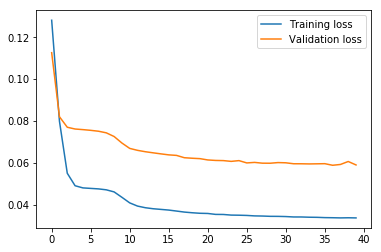

In [413]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

Let us now predict and check how model has done on both Normal and Anomalous test dataset:

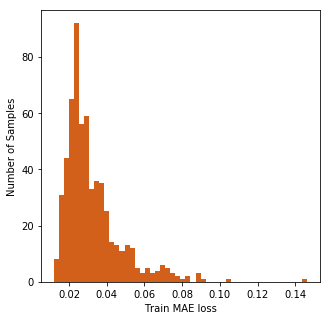

Reconstruction error threshold: 0.07225913222525962


In [414]:
#Normal test dataset
X_train_pred = model.predict(normal_X_test, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - normal_X_test), axis=1)

plt.figure(figsize=(5,5))
plt.hist(train_mae_loss, bins=50, color ='#d2601a')
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');
plt.show()

threshold = np.percentile(train_mae_loss,97.5) # This is a clean normal data.
print('Reconstruction error threshold: {}'.format(threshold))

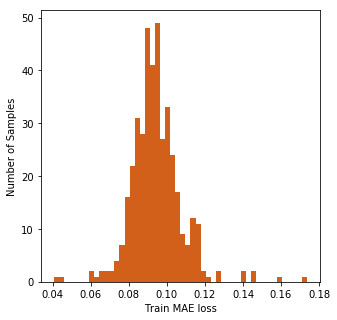

In [415]:
#Anomaly test dataset
X_train_pred = model.predict(anomaly_X_test, verbose=0)
train_mae_loss_a = np.mean(np.abs(X_train_pred - anomaly_X_test), axis=1)

plt.figure(figsize=(5,5))
plt.hist(train_mae_loss_a, bins=50, color ='#d2601a')
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');
plt.show()


Let us have a look at both of them side by side and check how did we do?

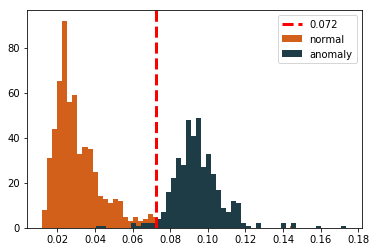

In [416]:
plt.hist(train_mae_loss, bins=50, label ='normal', color ='#d2601a')
plt.hist(train_mae_loss_a, bins=50, label ='anomaly', color ='#1d3c45')
plt.axvline(threshold, color = 'r', linewidth =3, linestyle ='dashed', label ='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.show()

We can infer from the above plot that we have identied most of the normal and anomalous ECG into correctly. Our model is able to separate normal and anomaly very well.

In [417]:
#Normal Class
preds = tf.math.less(train_mae_loss, threshold)
preds.shape
tf.math.count_nonzero(preds)

<tf.Tensor: shape=(), dtype=int64, numpy=577>

Normal Class Out of 592, our model can identify correctly 577 rocords that gives the accuracy of 97.4%. 

In [418]:
#Anomaly Class
preds_a = tf.math.greater(train_mae_loss_a, threshold)
preds_a.shape
tf.math.count_nonzero(preds_a)

<tf.Tensor: shape=(), dtype=int64, numpy=397>

For Anomaly Class Out of 408, our model can identify correctly 397 rocords that gives the accuracy of 97.3%. 